# Сегментация изображений. Архитектура U-Net

__Использованные матриалы__

* [U-Net](https://www.machinelearningnuggets.com/image-segmentation-with-u-net-define-u-net-model-from-scratch-in-keras-and-tensorflow/)
* [Kaggle dataset](https://www.kaggle.com/competitions/data-science-bowl-2018/data?ref=machinelearningnuggets.comv)
* [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/)
* [Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)
* [Сoncatenate layer](https://keras.io/api/layers/merging_layers/concatenate/)

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Пример конкатенации двух массивов

In [2]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [3]:
x = np.arange(20).reshape(2, 2, 5)
y = np.arange(20, 40).reshape(2, 2, 5)
x_concat_y = tf.keras.layers.Concatenate(axis=-1)([x, y])

x, y, x_concat_y

(array([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9]],
 
        [[10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19]]]),
 array([[[20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29]],
 
        [[30, 31, 32, 33, 34],
         [35, 36, 37, 38, 39]]]),
 <tf.Tensor: shape=(2, 2, 10), dtype=int64, numpy=
 array([[[ 0,  1,  2,  3,  4, 20, 21, 22, 23, 24],
         [ 5,  6,  7,  8,  9, 25, 26, 27, 28, 29]],
 
        [[10, 11, 12, 13, 14, 30, 31, 32, 33, 34],
         [15, 16, 17, 18, 19, 35, 36, 37, 38, 39]]])>)

## Загрузка датасета с Kaggle

In [4]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

## Изменение размера изобаржений до заданных размеров для оптимизации работы сети

In [5]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    y[n] = mask 

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 670/670 [02:58<00:00,  3.75it/s]


## Разделение датасета

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [46]:
X.shape

(670, 128, 128, 3)

## Изменение размера тестовых изобаржений до заданных размеров для оптимизации работы сети

In [7]:
# test images
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('Done!')

Resizing test images


100%|███████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 59.93it/s]

Done!


## Визуализация случайного изображения

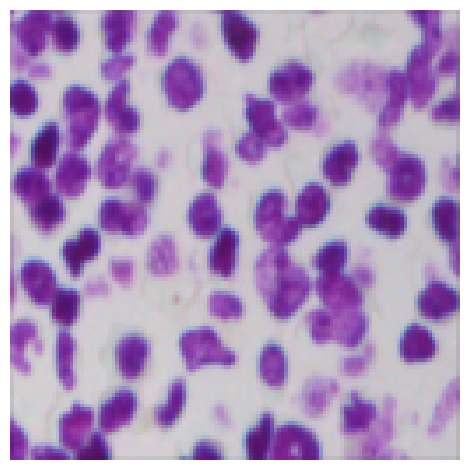

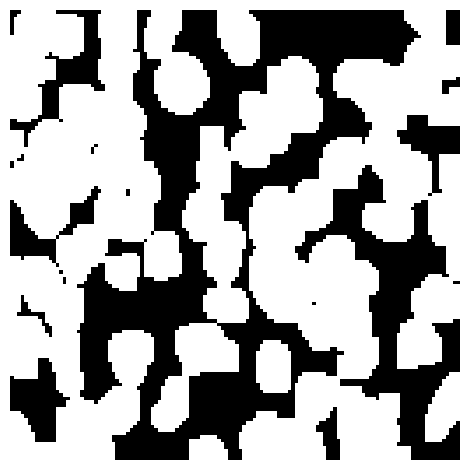

In [8]:
image_x = random.randint(0, len(X_train))
plt.axis("off")
imshow(X_train[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y_train[image_x]))
plt.show()

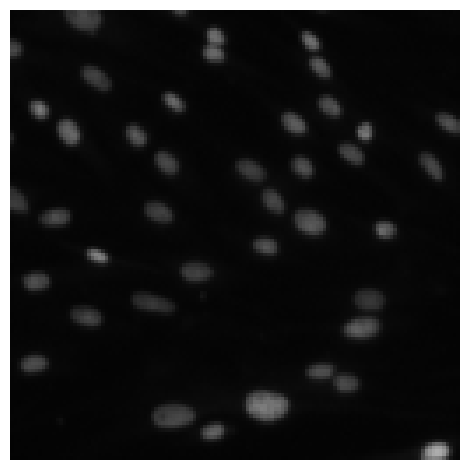

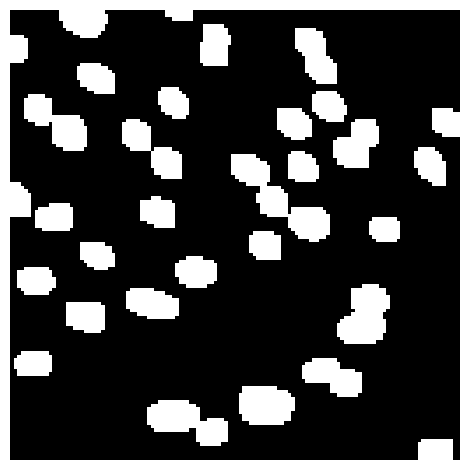

In [9]:
image_x = random.randint(0, len(X_test))
plt.axis("off")
imshow(X_test[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y_test[image_x]))
plt.show()

## Построение модели

Архитектура:

Contraction:
* Convolution
* Drop out  
* Batch normalization
* ReLu
* Max pooling
  
Expansion:
* Upsampling – Conv2DTranspose  
* Concatenate to combine upsampled and downsampled features
* Batch normalization
* ReLU
* Convolution

In [10]:
num_classes = 1

In [11]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

 
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]  

 Total params: 1,400,033 (5.34 MB)

 Trainable params: 1,398,081 (5.33 MB)

 Non-trainable params: 1,952 (7.62 KB)

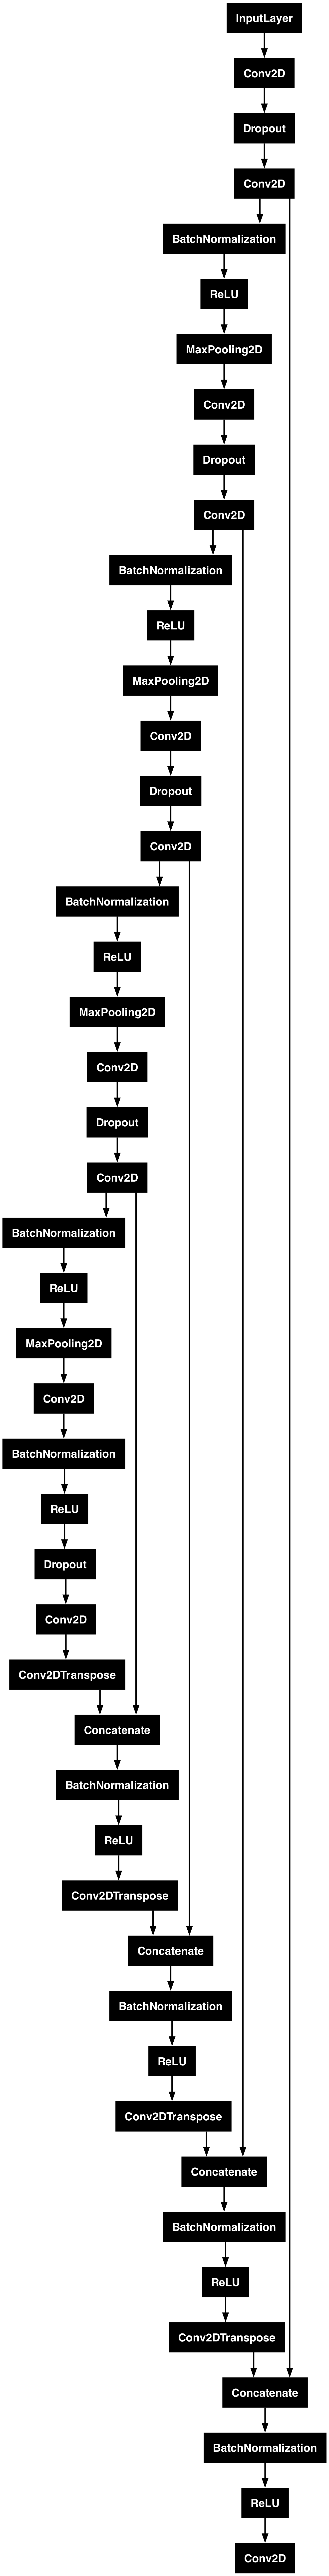

In [12]:
tf.keras.utils.plot_model(model, "model.png")

In [13]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25


/Users/grindelf/Programming/JUPITER/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - accuracy: 0.6859 - loss: 0.6745 - val_accuracy: 0.7947 - val_loss: 0.7163
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.8699 - loss: 0.3855 - val_accuracy: 0.8427 - val_loss: 0.5618
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - accuracy: 0.9192 - loss: 0.2685 - val_accuracy: 0.9157 - val_loss: 0.3230
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.9313 - loss: 0.2109 - val_accuracy: 0.9400 - val_loss: 0.2204
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 311ms/step - accuracy: 0.9414 - loss: 0.1779 - val_accuracy: 0.9502 - val_loss: 0.1991
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.9527 - loss: 0.1445 - val_accuracy: 0.9496 - val_loss: 0.1634
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 311ms/step - accuracy: 0.9499 - loss: 0.1456 - val_accuracy: 0.9535 - val_loss: 0.1481
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy: 0.9494 - loss: 0.1430 - val_accuracy: 0.9530 - val

In [14]:
model.save('wide-u-net.h5')

In [15]:
# model = tf.keras.models.load_model('wide-u-net.h5')

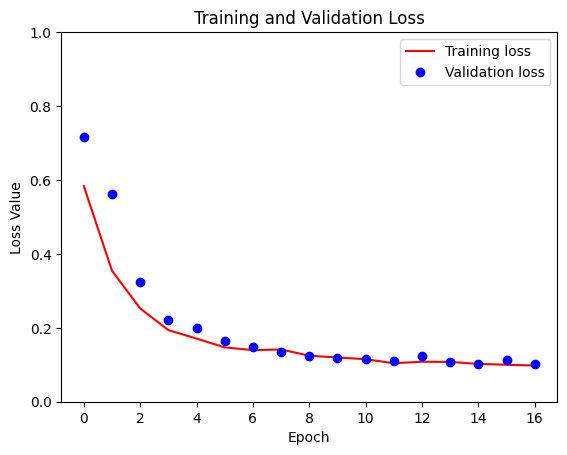

In [16]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

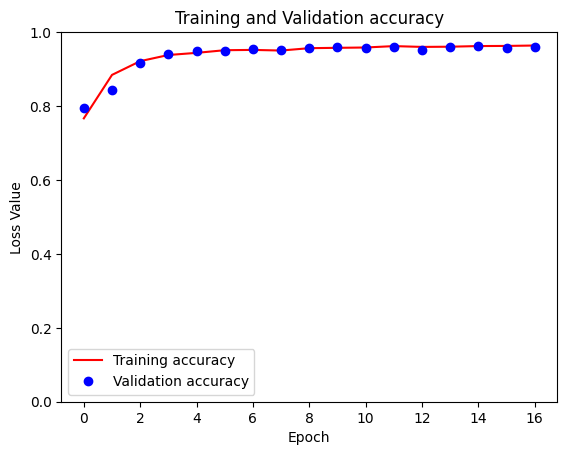

In [17]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9615 - loss: 0.1017
Test accuracy: 0.961


In [35]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [36]:
i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]

In [37]:
prediction = model.predict(sample_image[tf.newaxis, ...])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [38]:
predicted_mask = (prediction > 0.5).astype(np.uint8)

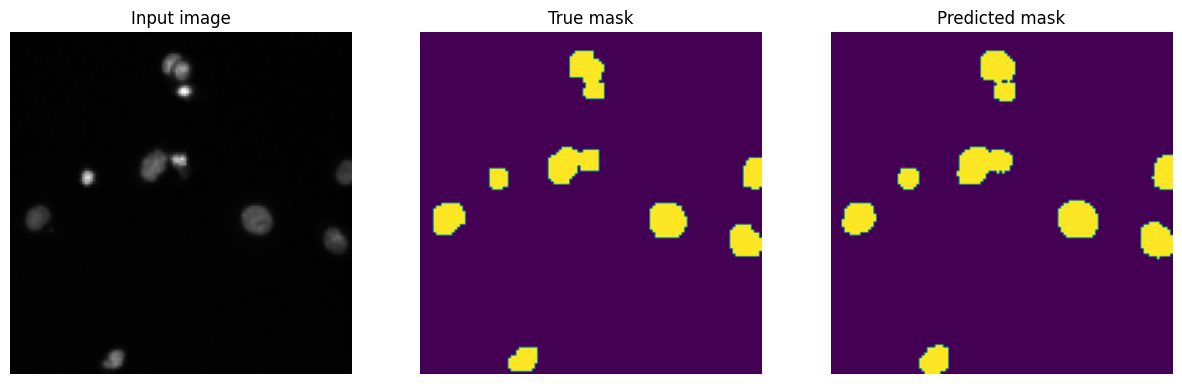

In [39]:
display([sample_image, sample_mask,predicted_mask])

## Уменьшение ёмкости нейросети (уменьшение глубины до 3)

In [23]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)
 
model2 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_11[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_5[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ re_lu_9[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_13[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_6[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ re_lu_10[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │     73,984 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32, 32,    │          0 │ re_lu_11[0][0]  

 Total params: 719,265 (2.74 MB)

 Trainable params: 718,465 (2.74 MB)

 Non-trainable params: 800 (3.12 KB)

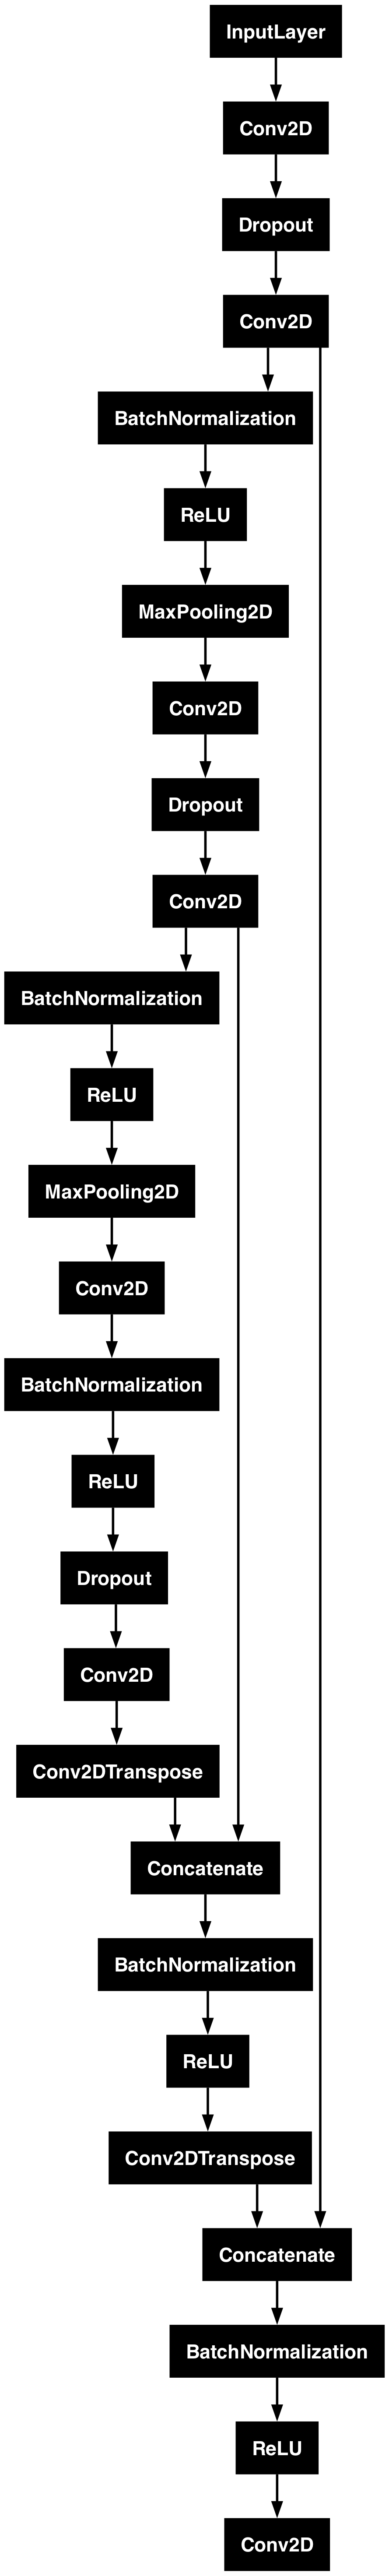

In [24]:
tf.keras.utils.plot_model(model2, "model2.png")

In [25]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model2.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25


/Users/grindelf/Programming/JUPITER/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_47']. Received: the structure of inputs=*
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.7562 - loss: 0.6164 - val_accuracy: 0.7995 - val_loss: 0.6174
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - accuracy: 0.8979 - loss: 0.3447 - val_accuracy: 0.9174 - val_loss: 0.3960
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.9249 - loss: 0.2566 - val_accuracy: 0.9413 - val_loss: 0.2737
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.9445 - loss: 0.1958 - val_accuracy: 0.9376 - val_loss: 0.2184
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 474ms/step - accuracy: 0.9521 - loss: 0.1731 - val_accuracy: 0.9499 - val_loss: 0.1798
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 487ms/step - accuracy: 0.9551 - loss: 0.1468 - val_accuracy: 0.9414 - val_loss: 0.1715
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 477ms/step - accuracy: 0.9590 - loss: 0.1332 - val_accuracy: 0.9554 - val_loss: 0.1391
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - accuracy: 0.9538 - loss: 0.1367 - val_accuracy: 0.949

In [26]:
model2.save('lighter-u-net-1.h5')

In [27]:
# model2 = tf.keras.models.load_model('lighter-u-net-1.h5')

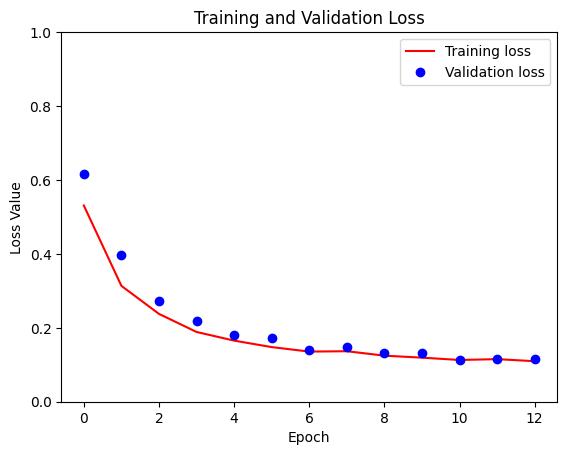

In [28]:
loss = model2.history.history['loss']
val_loss = model2.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

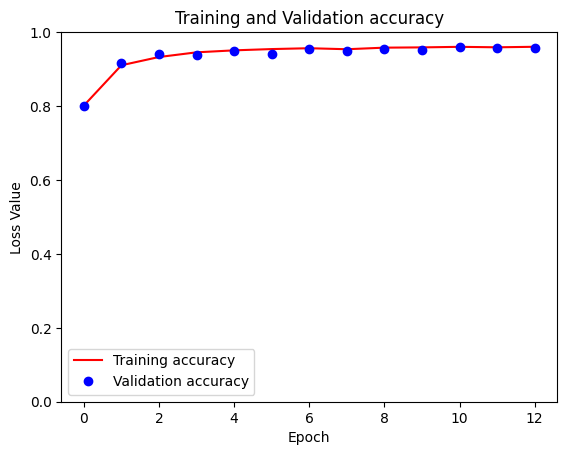

In [29]:
accuracy = model2.history.history['accuracy']
val_accuracy = model2.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [30]:
prediction2 = model2.predict(sample_image[tf.newaxis, ...])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [40]:
predicted_mask2 = (prediction2 > 0.5).astype(np.uint8)

## В случае менее глубокой сети

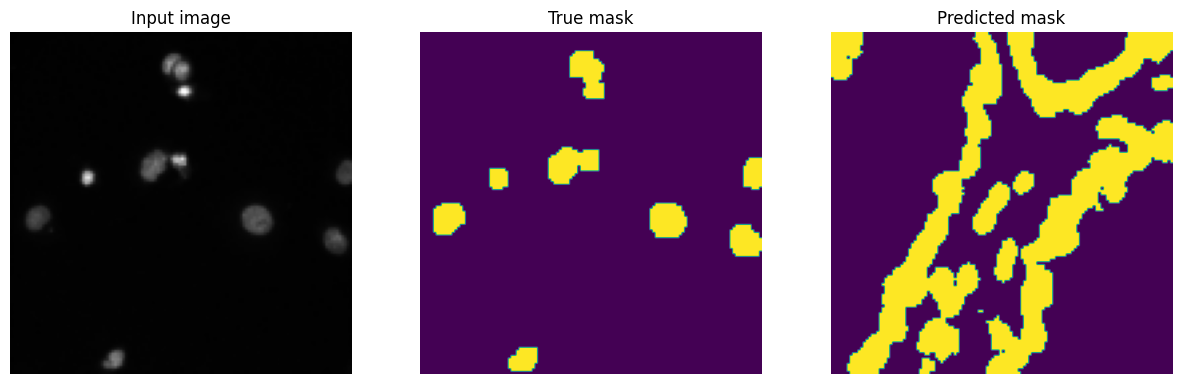

In [41]:
display([sample_image, sample_mask, predicted_mask2])

## В случае более глубокой сети

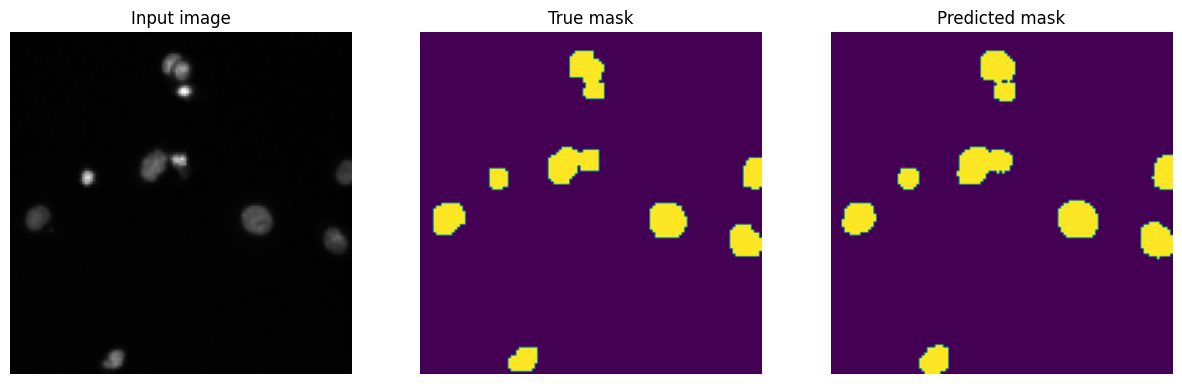

In [42]:
display([sample_image, sample_mask, predicted_mask])

In [43]:
test_loss2, test_acc2 = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc2:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.9566 - loss: 0.1142
Test accuracy: 0.956
